In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # viz
import seaborn as sns # viz
import sklearn
from scipy import stats
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import sklearn.metrics
from scipy import stats
import scikitplot as skplt

In [2]:
path ='/content/gdrive'
from google.colab import drive
drive.mount(path)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/BethData'

/content/gdrive/MyDrive/BethData


In [4]:
train = pd.read_csv("labelled_training_data.csv", engine = "python",on_bad_lines='skip')
test = pd.read_csv("labelled_testing_data.csv" ,engine = 'python',on_bad_lines='skip')

In [5]:
class Data_Process:

    def __init__(self, split='train'):
            if split == 'train':
                data = train
            elif split == 'test':
                data = test
            else:
                raise Exception("Error: Invalid 'split' given")
            self.name = split
            # Select columns and perform pre-processing
            labels = pd.DataFrame(data[["sus"]])
            data = pd.DataFrame(data[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
            data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
            data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
            data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
            data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
            data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
            data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error
            self.data = data
            self.labels = labels



In [6]:
training = Data_Process()
testing = Data_Process(split = 'test')

In [7]:
sampleTrain = pd.concat([training.data, training.labels], axis=1).sample(frac = 0.10)

In [8]:
np.unique(sampleTrain['sus'], return_counts=True)
sample_x = sampleTrain.drop(labels='sus', axis=1)
sample_y = pd.DataFrame(sampleTrain['sus'])

In [9]:
sampleTest = pd.concat([testing.data, testing.labels], axis=1).sample(frac = 0.10)

In [10]:
np.unique(sampleTest['sus'], return_counts=True)
sampleTest_x = sampleTrain.drop(labels='sus', axis=1)
sampleTest_y = pd.DataFrame(sampleTrain['sus'])

##Local Outlier Factor

In [ ]:
LOF = LocalOutlierFactor(n_neighbors = 5,contamination = 0.05)

In [ ]:
predictLOF = pd.DataFrame()
predictLOF['Predicted Values'] = LOF.fit_predict(testing.data)
predictLOF['Anomalies'] = predictLOF['Predicted Values'].map({1:0,-1:1})

In [ ]:
np.unique(predictLOF['Anomalies'], return_counts = True)

(array([0, 1]), array([188849,    118]))

In [ ]:
f1 = sklearn.metrics.f1_score(testing.labels, predictLOF['Anomalies'], average = 'macro')
accuracy = sklearn.metrics.accuracy_score(testing.labels, predictLOF['Anomalies'])
roc = sklearn.metrics.roc_auc_score(testing.labels, predictLOF['Anomalies'])
print(roc)
print(f1)
print(accuracy)

0.4988962775591225
0.08503997908088588
0.09278868797197394


In [ ]:
np.unique(predictLOF['Anomalies'], return_counts=True)

(array([0, 1]), array([188849,    118]))

## One Class SVM Model


In [ ]:
One_SVM = OneClassSVM(nu=0.05, kernel = 'rbf', gamma = 'auto').fit(training.data)

In [ ]:
predictSVM = pd.DataFrame()
predictSVM['Predicted Values'] = One_SVM.predict(testing.data)
predictSVM['Anomalies'] = predictSVM['Predicted Values'].map({1:0,-1:1})

In [ ]:
np.unique(predictSVM['Predicted Values'], return_counts=True)

(array([-1,  1]), array([169311,  19656]))

In [ ]:
f1 = sklearn.metrics.f1_score(testing.labels, predictSVM['Anomalies'], average = 'macro')
accuracy = sklearn.metrics.accuracy_score(testing.labels, predictSVM['Anomalies'])
roc = sklearn.metrics.roc_auc_score(testing.labels, predictSVM['Anomalies'])
print(roc)
print(f1)
print(accuracy)

0.8344120796271708
0.816887703529289
0.9350574438923198


##Training Isolation Forest Model

In [11]:
clf = IsolationForest(random_state=20,contamination=0.05).fit(training.data)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [12]:
np.unique(training.labels, return_counts =True)

(array([0, 1]), array([761875,   1269]))

In [13]:
predict = pd.DataFrame()
predict['Predicted Values'] = clf.predict(testing.data)
predict['Anomalies'] = predict['Predicted Values'].map({1:0,-1:1})

In [14]:
np.unique(predict['Predicted Values'], return_counts=True)

(array([-1,  1]), array([149317,  39650]))

In [15]:
f1 = sklearn.metrics.f1_score(testing.labels, predict['Anomalies'])
accuracy = sklearn.metrics.accuracy_score(testing.labels, predict['Anomalies'])
roc = sklearn.metrics.roc_auc_score(testing.labels, predict['Anomalies'])

In [16]:
print(roc)
print(f1)
print(accuracy)

0.847868506510074
0.913628201611093
0.8533818074055258


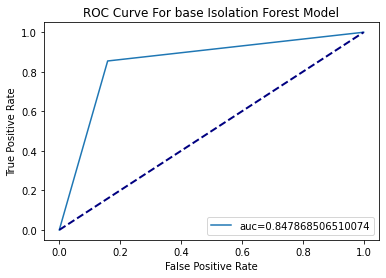

In [46]:
fpr, tpr, _ = sklearn.metrics.roc_curve(testing.labels, predict['Anomalies'])
auc = sklearn.metrics.roc_auc_score(testing.labels, predict['Anomalies'])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve For base Isolation Forest Model")
plt.legend(loc="lower right")
plt.show()

In [48]:
cf_matrix = sklearn.metrics.confusion_matrix(testing.labels, predict['Anomalies'])
print(cf_matrix)


[[ 14726   2782]
 [ 24924 146535]]


Text(0.5, 15.0, 'Predicted label')

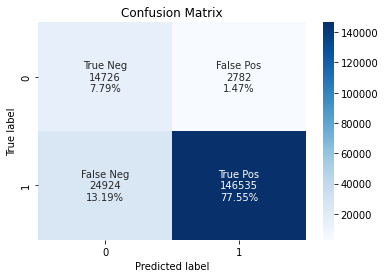

In [58]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

Testing predictive power of Isolation forest trained on 10% Random Sample

In [59]:
clf_sample = IsolationForest(random_state=20,contamination=0.05).fit(sample_x)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [60]:
predict_sample = pd.DataFrame()
predict_sample['Predicted Values'] = clf_sample.predict(testing.data)
predict_sample['Anomalies'] = predict_sample['Predicted Values'].map({1:0,-1:1})

In [61]:
f1_sample = sklearn.metrics.f1_score(testing.labels, predict_sample['Anomalies'])
accuracy_sample = sklearn.metrics.accuracy_score(testing.labels, predict_sample['Anomalies'])
roc_sample = sklearn.metrics.roc_auc_score(testing.labels, predict_sample['Anomalies'])

In [62]:
print(roc_sample)
print(f1_sample)
print(accuracy_sample)

0.8614770848188155
0.9135455787758726
0.8536940312329666


In [80]:
##optimize via 10x grid search cross validation
from sklearn import metrics
from sklearn import model_selection

class Tune_parameters:

    def __init__(self,model,x,y,param_grid, score = "f1_macro"):
        clf = model.fit(x)

        self.random_dt_estimator = model_selection.RandomizedSearchCV(clf, 
                                                 param_grid,
                                                 scoring=score, 
                                                 refit=True,
                                                 cv=10, 
                                                 return_train_score=True,
                                                 verbose = 0)
        self.random_dt_estimator.fit(x, y)

Tune Model Using F1_macro score (Macro average is best for imbalanced classification because it treats each class equally) instead of the weighted F1 score which would give too much weight to the non-anomamly class.

In [ ]:
param_grid = {'n_estimators': list(range(100, 500, 10)), ##Testing optimum number of tres in the ensemble
                  'contamination': list(np.arange(0.001, 0.1, 0.001)), ##testing contamination parameters (Most sensitive parameter)
                  'max_features': list(range(1, 7, 1))}
model = IsolationForest()
tunedISO = Tune_parameters(model,sample_x,sample_y,param_grid)

In [67]:
tunedISO.random_dt_estimator.best_params_

{'n_estimators': 280, 'max_features': 5, 'contamination': 0.009000000000000001}

In [73]:
clf_tuned = IsolationForest(max_features=5,contamination=0.009).fit(training.data)
predict_tuned = pd.DataFrame()
predict_tuned['Predicted Values'] = clf_tuned.predict(testing.data)
predict_tuned['Anomalies'] = predict_tuned['Predicted Values'].map({1:0,-1:1})


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


0.9147821997830249
0.9180729415913155
0.8622934163107844


In [79]:
f1_tuned = sklearn.metrics.f1_score(testing.labels, predict_tuned['Anomalies'])
accuracy_tuned = sklearn.metrics.accuracy_score(testing.labels, predict_tuned['Anomalies'])
roc_tuned = sklearn.metrics.roc_auc_score(testing.labels, predict_tuned['Anomalies'])
recall_tuned = sklearn.metrics.recall_score(testing.labels, predict_tuned['Anomalies'])
precision_tuned = sklearn.metrics.precision_score(testing.labels, predict_tuned['Anomalies'])
print("ROC:" + str(roc_tuned))
print("f1: " + str(f1_tuned))
print("Accuracy:" + str(accuracy_tuned))
print("Recall: " + str(recall_tuned))
print("Precision: " + str(precision_tuned))

ROC:0.9147821997830249
f1: 0.9180729415913155
Accuracy:0.8622934163107844
Recall: 0.8503548953394106
Precision: 0.9975096637361885


In [ ]:
##Plot the ROC curve

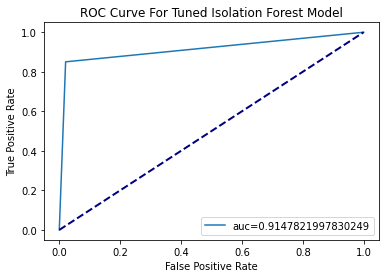

In [74]:
fpr, tpr, _ = sklearn.metrics.roc_curve(testing.labels, predict_tuned['Anomalies'])
auc = sklearn.metrics.roc_auc_score(testing.labels, predict_tuned['Anomalies'])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve For Tuned Isolation Forest Model")
plt.legend(loc="lower right")
plt.show()

In [75]:
cf_matrix = sklearn.metrics.confusion_matrix(testing.labels, predict_tuned['Anomalies'])
print(cf_matrix)

[[ 17144    364]
 [ 25658 145801]]


Text(0.5, 15.0, 'Predicted label')

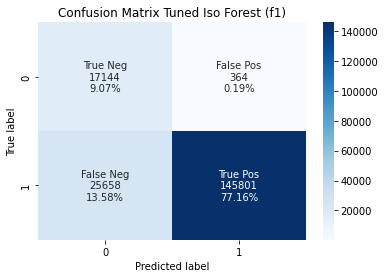

In [86]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("Confusion Matrix Tuned Iso Forest (f1)")
plt.ylabel('True label')
plt.xlabel('Predicted label')